 * `Imbort Libraries`

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

* `Read Dataset`

In [151]:
DATA_PATH = os.path.join(os.getcwd(), '..', 'dataset', 'loan_approval_dataset.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [152]:
df.drop(columns='loan_id',axis=1,inplace=True)

In [153]:
df.columns = df.columns.str.strip().str.replace(' ','_')

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [155]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


* `EDA`

In [156]:
df.isna().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [157]:
df.duplicated().sum()

np.int64(0)

In [158]:
df.dtypes

no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

Feature Engineering

In [159]:
# To combine the asset features
df['total_assets'] = df['residential_assets_value'] + df['commercial_assets_value'] + df['luxury_assets_value'] + df['bank_asset_value']

In [160]:
df['loan_to_income'] = df['loan_amount'] / df['income_annum']
df['loan_to_assets_ratio'] = df['loan_amount'] / df['total_assets'] + 1

In [161]:
df['education'].value_counts()

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

In [162]:
df['self_employed'].value_counts()

self_employed
Yes    2150
No     2119
Name: count, dtype: int64

In [163]:
# Target Column
df['loan_status'].value_counts()

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

In [164]:
# OH MY GAT THIS IS Imbalanced Data

* `Data VIZ & Handling Outlier`

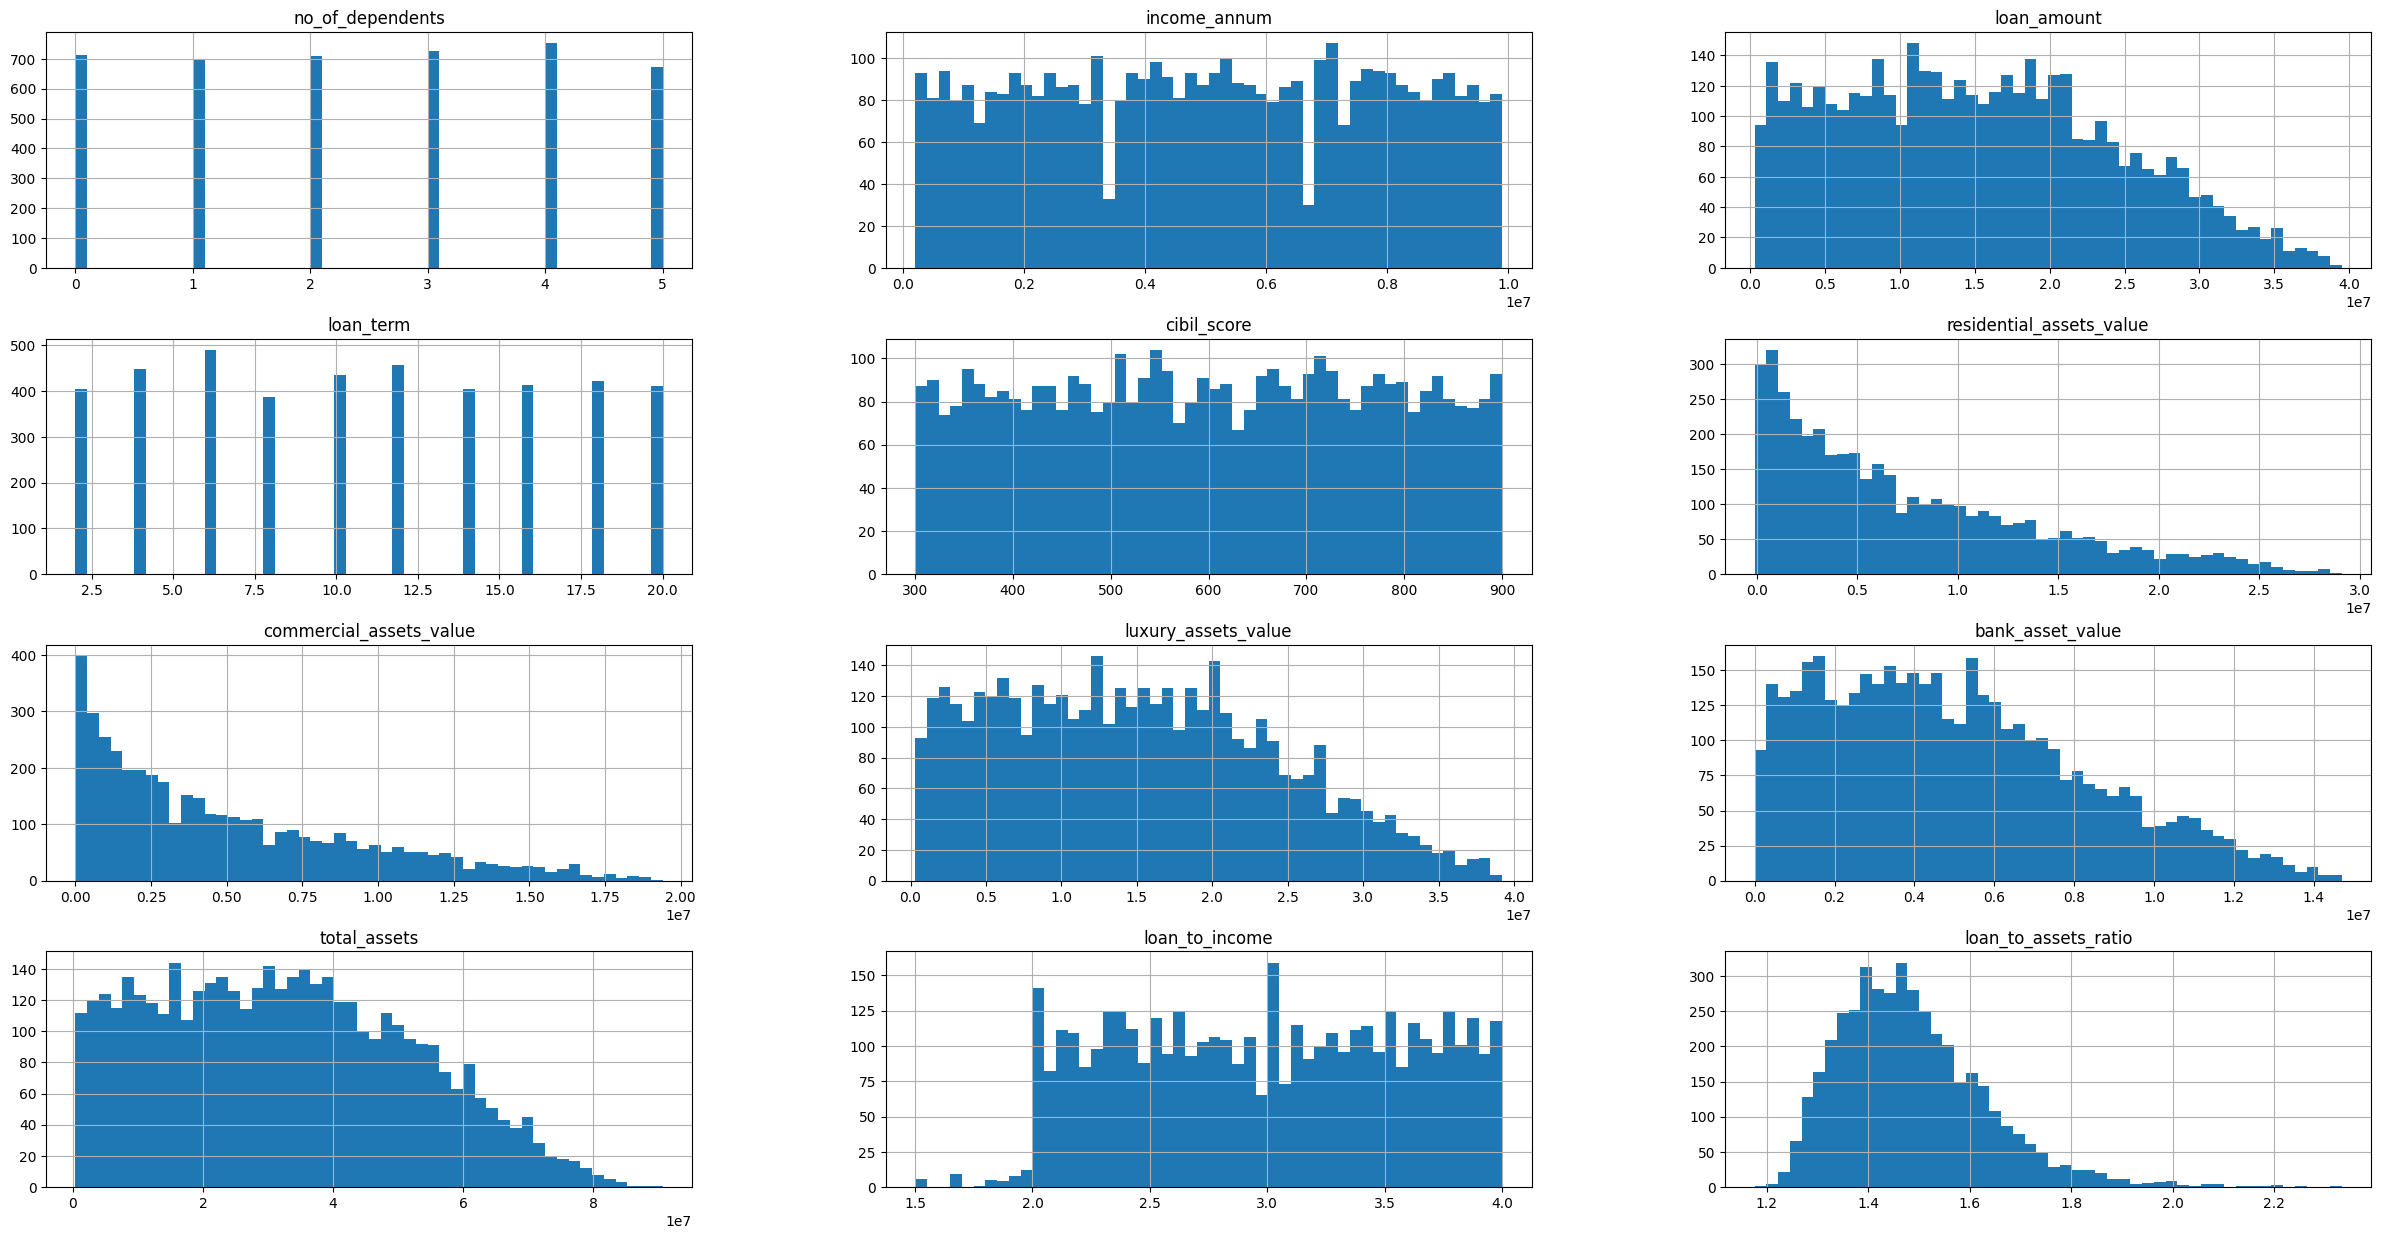

In [165]:
df.hist(bins=50,figsize=(30,15))
plt.show()

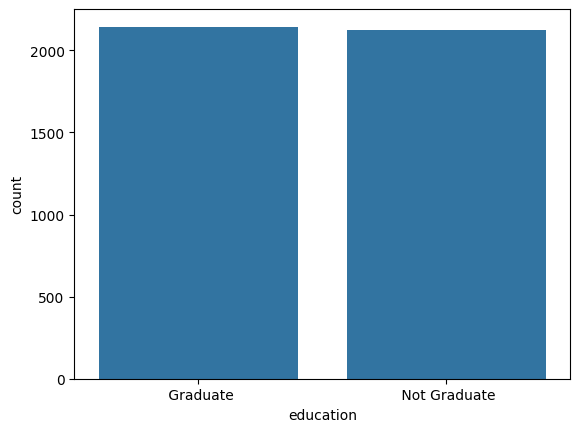

In [166]:
sns.countplot(data=df,x='education', order=df['education'].value_counts().index.tolist())
plt.show()

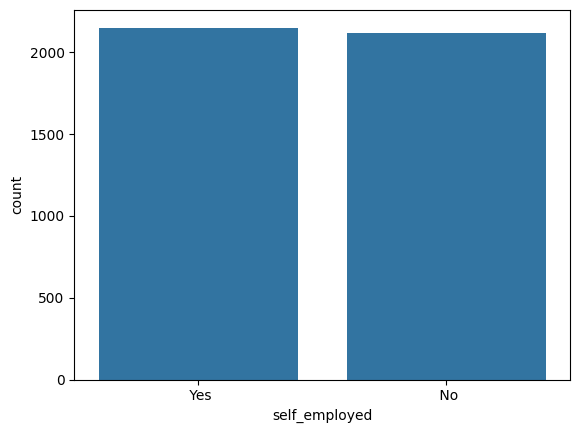

In [167]:
sns.countplot(data=df,x='self_employed', order=df['self_employed'].value_counts().index.tolist())
plt.show()

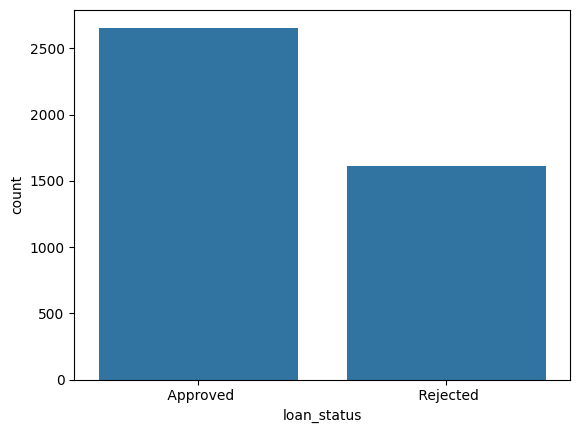

In [168]:
sns.countplot(data=df,x='loan_status');

In [169]:
df[['self_employed','income_annum']].groupby(by='self_employed')['income_annum'].mean()

self_employed
No     5.052430e+06
Yes    5.065721e+06
Name: income_annum, dtype: float64

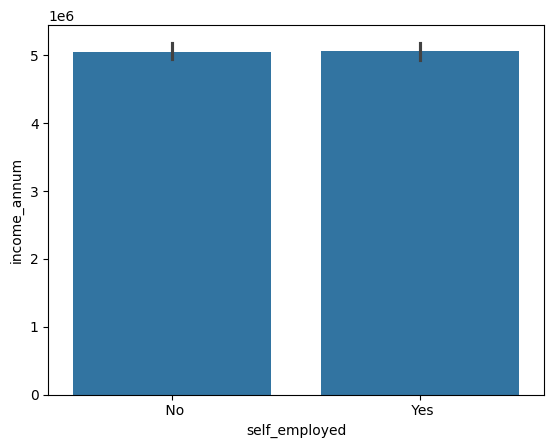

In [170]:
sns.barplot(data=df,x='self_employed',y='income_annum',estimator='mean');

In [171]:
df[['education','income_annum']].groupby(by='education')['income_annum'].mean()

education
Graduate        5.091604e+06
Not Graduate    5.026353e+06
Name: income_annum, dtype: float64

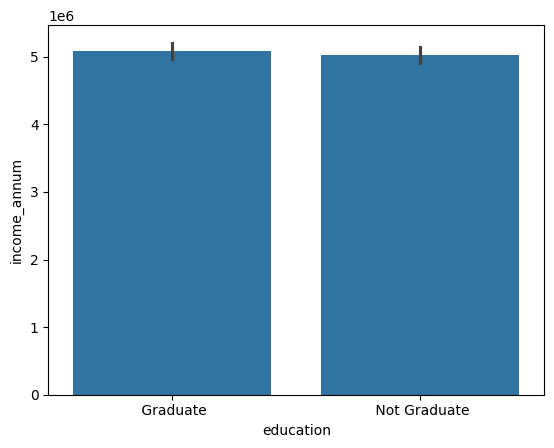

In [172]:
sns.barplot(data=df,x='education',y='income_annum',estimator='mean');

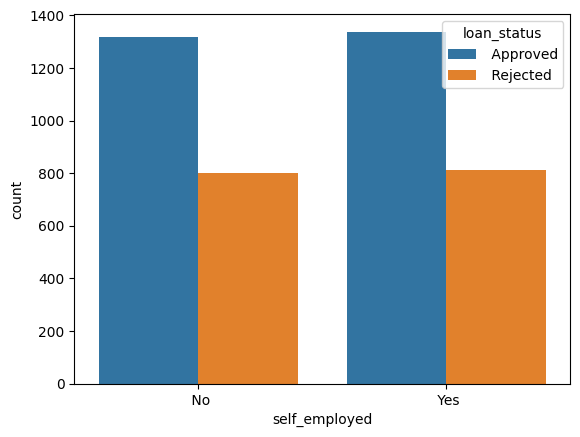

In [173]:
sns.countplot(data=df,x='self_employed',hue='loan_status')
plt.show()

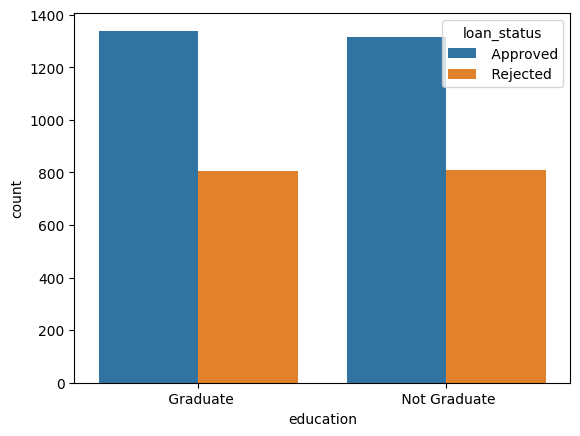

In [174]:
sns.countplot(data=df,x='education',hue='loan_status')
plt.show()

* `Split to train & test `


In [175]:
X = df.drop(columns='loan_status',axis=1)
y = df['loan_status']

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=45)

In [177]:
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (3415, 14)
y_train.shape 	 (3415,)
******************************
X_test.shape 	 (854, 14)
y_test.shape 	 (854,)


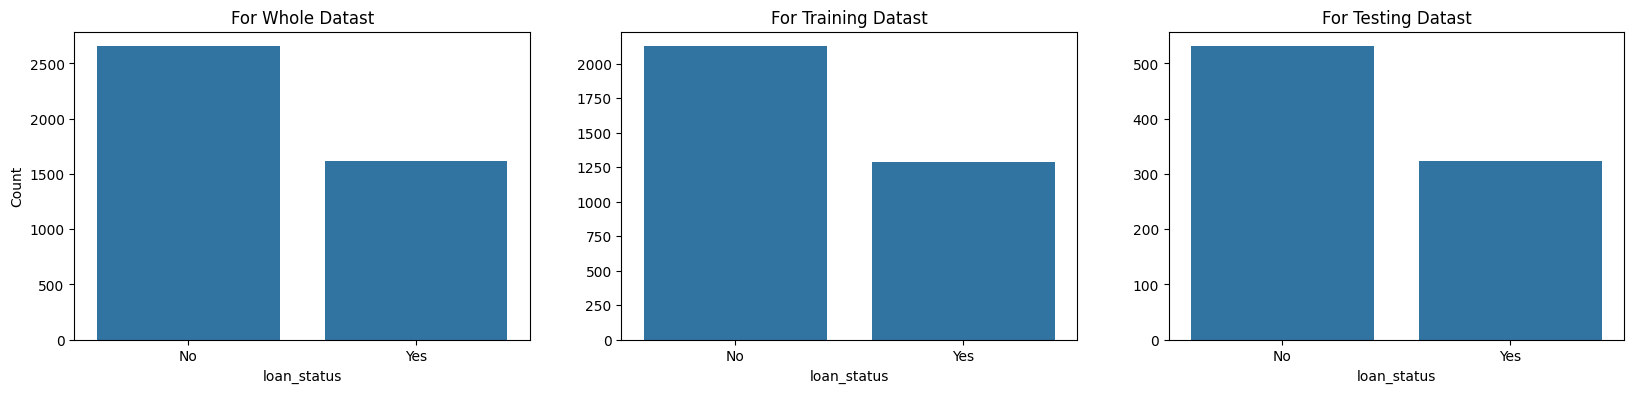

In [178]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

In [179]:
df.head(2)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,total_assets,loan_to_income,loan_to_assets_ratio
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,50700000,3.114583,1.589744
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,17000000,2.975610,1.717647


In [180]:
df.dtypes

no_of_dependents              int64
education                    object
self_employed                object
income_annum                  int64
loan_amount                   int64
loan_term                     int64
cibil_score                   int64
residential_assets_value      int64
commercial_assets_value       int64
luxury_assets_value           int64
bank_asset_value              int64
loan_status                  object
total_assets                  int64
loan_to_income              float64
loan_to_assets_ratio        float64
dtype: object

* `Feature Selection & Preporcessing`

In [181]:
num_cols = [
    'no_of_dependents',
    'income_annum',
    'loan_amount',
    'loan_term',
    'cibil_score',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value',
    'total_assets',
    'loan_to_income',
    'loan_to_assets_ratio'
]

categ_cols = ['education', 'self_employed']



In [182]:
# Numerical cols (num_cols) & Target cols --> ANOVA
_, p_val = f_classif(X=X_train[num_cols], y=y_train)
p_val   # All features p-value less than 0.05 --> Reject H0 --> There is an asscociation

array([3.47727528e-01, 7.93560763e-01, 1.34281732e-01, 1.19833049e-08,
       0.00000000e+00, 4.93445301e-01, 4.46860691e-01, 6.34664203e-01,
       7.97801196e-01, 8.12959265e-01, 5.76295130e-07, 4.05893341e-02])

In [183]:
_,p_val = chi2(X=OrdinalEncoder().fit_transform(X_train[categ_cols]),y=y_train)
p_val

array([0.76398452, 0.571652  ])

In [184]:
df.drop(columns=['no_of_dependents','residential_assets_value','commercial_assets_value','luxury_assets_value'],inplace=True,axis=1)

In [185]:
#pipline

num_Pipline = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('scale',StandardScaler())
])
categ_pipline = Pipeline([
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(sparse_output=False,drop='first'))
])
target_pipline = Pipeline([
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('ohe',OneHotEncoder(sparse_output=False,drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical',num_Pipline,num_cols),
    ('categoric',categ_pipline,categ_cols),
    
])
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)

In [186]:
X_train_final.shape , y_train.shape

((3415, 14), (3415,))

In [187]:
X_test_final.shape , y_test.shape

((854, 14), (854,))

* `Deal with Imbalanced Dataset`

In [188]:
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)
dict_weight = {}
for i in range(2):
    dict_weight[i] = vals_count[i]
    
dict_weight

{0: np.float64(0.37774524158125916), 1: np.float64(0.6222547584187409)}

In [189]:
over = SMOTE(k_neighbors=5,random_state=42,sampling_strategy=.8)
X_train_final_resampled , y_train_resampled = over.fit_resample(X_train_final,y_train)

In [190]:
MODEL_FOLDER_PATH = os.path.join(os.getcwd(),'..','models')
os.makedirs(MODEL_FOLDER_PATH,exist_ok=True)

In [192]:
joblib.dump(preprocessor,os.path.join(MODEL_FOLDER_PATH,'preprocessor.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\loan_data\\notebooks\\..\\models\\preprocessor.pkl']

* `Building Models `
* `Using f1_score`

In [197]:
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final,y_train)

y_train_predict_log = log_clf.predict(X_train_final)
y_test_predict_log = log_clf.predict(X_test_final)

score_train_log = f1_score(y_train,y_train_predict_log)
score_test_log = f1_score(y_test,y_test_predict_log)

print(f"The f1_score using logistic model for traning dataset is {score_train_log*100:.2f}")
print(f"The f1_score using logistic model for testing dataset is {score_test_log*100:.2f}")

The f1_score using logistic model for traning dataset is 88.57
The f1_score using logistic model for testing dataset is 88.65


In [198]:
log_clf = LogisticRegression(C=1.5,class_weight=dict_weight)
log_clf.fit(X_train_final,y_train)

y_train_predict_log = log_clf.predict(X_train_final)
y_test_predict_log = log_clf.predict(X_test_final)

score_train_log = f1_score(y_train,y_train_predict_log)
score_test_log = f1_score(y_test,y_test_predict_log)

print(f"The f1_score using logistic model for traning dataset  with class weights is {score_train_log*100:.2f}")
print(f"The f1_score using logistic model for testing dataset with class weights  is {score_test_log*100:.2f}")

The f1_score using logistic model for traning dataset  with class weights is 90.04
The f1_score using logistic model for testing dataset with class weights  is 91.07


In [199]:
log_clf = LogisticRegression(C=1.5,class_weight=dict_weight)
log_clf.fit(X_train_final_resampled,y_train_resampled)

y_train_predict_log = log_clf.predict(X_train_final)
y_test_predict_log = log_clf.predict(X_test_final)

score_train_log = f1_score(y_train,y_train_predict_log)
score_test_log = f1_score(y_test,y_test_predict_log)

print(f"The f1_score using logistic model for traning dataset  with SMOTE is {score_train_log*100:.2f}")
print(f"The f1_score using logistic model for testing dataset with SMOTE  is {score_test_log*100:.2f}")

The f1_score using logistic model for traning dataset  with SMOTE is 90.39
The f1_score using logistic model for testing dataset with SMOTE  is 90.72
